# SI Model with no demographics

We will begin with perhaps the simplest possible model of an infectious disease - the SI model without demography.  This model hsa two classes of individuals, the infective and the susceptible, and 1 parameter, $\beta$, describing the per-timestep, per-infective person rate at which susceptibles transition to infectives.

$$
\dot{S} = -\frac{\beta*S*I}{N} \\

\dot{I} = \frac{\beta*S*I}{N}
$$

Noting that $S = N-I$, we can substitute $S$ in the second equation to get a standard form logistic equation

$$
\dot{I} = \beta \frac{(I-N)I}{N} = \beta I (1 - \frac{I}{N})
$$

With solution 
$$
\frac{N}{1+(\frac{N}{I_0}-1)e^{-\beta t}}
$$


This notebook tests the implementation and behavior of the model as follows:
### Contruct the model
In the first few cells, we do all the necessary imports.  Then we construct a single-patch LASER model with two components: Susceptibility and Transmission.  Finally, we initialize with a single infection and run.  The Susceptibility component endows both agents and patches in the model with a `susceptibility` quantity.  For the agents, this represents their state (infective = 0, susceptible = 1), and for the patch, it represents the total population of susceptible agents.  The differential equation above is converted into a stochastic finite difference equation

$$
\Delta I = Bin(S_t, 1-exp^{-\beta \Delta t \frac{I}{N}}) \\
S_{t+1} = S_t - \Delta I \\
I_{t+1} = I_t + \Delta I
$$


### Sanity check
The first test ensures certain basic constraints are being obeyed by the model.  We confirm that at each timestep, $S_t=N_t-I_t$.  We also confirm that $I_t = I_0 + \sum_{t'=0}^t \Delta I_{t'}$  

### Scientific test
Finally, we come to the scientific test.  We select a few values of $\beta$



## Constructing the model

In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize, curve_fit
from laser_core.propertyset import PropertySet
from laser_generic import Model
from laser_generic.susceptibility import Susceptibility
from laser_generic.transmission import Transmission
from laser_generic.utils import seed_infections_randomly_SI

f"{np.__version__=}"

"np.__version__='1.26.4'"

A note that order of the model components matters, because of how recording of relevant statistics into outputs occurs.  If transmission comes before susceptibility, then we have $N = S+I+\Delta I$, because we record $I$, record $\Delta I$, do transmission, then record $S$ after the transmission process occurs.  With susceptibility first, we record $S$, then record $I$, then do transmission (and record $\Delta I$), and so we have $N = S+I$.

In [26]:
pop = 1e6
init_inf = 1
scenario = pd.DataFrame(data=[["homenode", pop, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "beta": 0.1})
model = Model(scenario, parameters)


model.components = [
    Susceptibility,
    Transmission,
]

seed_infections_randomly_SI(model, ninfections=init_inf)
model.run()

2024-12-19 15:04:17.035765: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:04:17.039185: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:01<00:00, 435.25it/s]

Completed the generic model at 2024-12-19 15:04:18.718207…
Model         :         1,750 µs
Susceptibility:       441,918 µs
Transmission  :     1,221,871 µs
Total:              1,665,539 microseconds


## First set of sanity checks

S = N-I:  True
I=sum(Delta I):  True


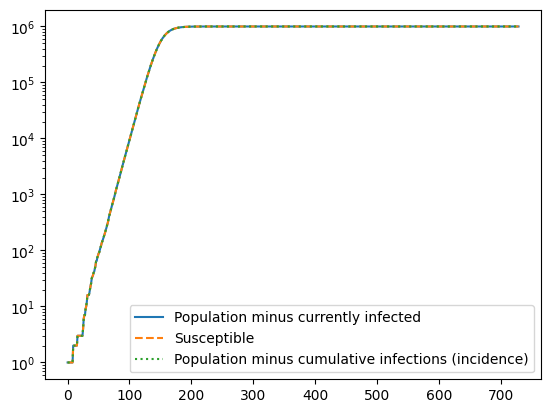

In [43]:
plt.plot(model.patches.cases.astype("int"))
plt.plot(model.patches.populations - model.patches.susceptibility.astype("int"), "--")
plt.plot(init_inf + np.insert(np.cumsum(model.patches.incidence[:-1]).astype("int"), 0, 0), ':')
plt.yscale("log")
plt.legend(["Population minus currently infected", "Susceptible", "Population minus cumulative infections (incidence)"])

print('S = N-I:  '+str(np.isclose(model.patches.susceptibility, model.patches.populations[:-1] - model.patches.cases).all()))
print('I=sum(Delta I):  '+str(np.isclose(np.squeeze(model.patches.cases)-init_inf, [0, *np.cumsum(model.patches.incidence[:-1])]).all()))

Because the model is stochastic, the early stages of the outbreak are a bit unpredictable, and to illustrate concordance between the model and the expected logistic growth curve, we add an offset $t_0$ to the logistic growth curve and optimize with respect to it.  The resulting plot should show good concordance between the model output and the expected logistic equation with the known model inputs $\beta$ and population.
The goodness of this fit could be turned into a strict pass/fail test down the line.

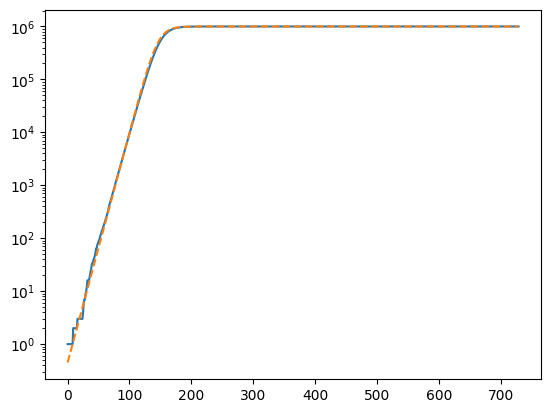

In [67]:
def SI_logistic(t, beta, size, t0):
    return size / (1 + (size - 1) * np.exp(-beta * (t - t0)))

plt.plot(model.patches.cases.astype("int"))

t = np.arange(model.params.nticks)

def objective(t0):
    return np.sum((1 - SI_logistic(t, model.params.beta, pop, t0)/np.squeeze(model.patches.cases.astype("int")))**2)

result = minimize(objective, x0=10)
t0_opt = result.x[0]


plt.plot(t, SI_logistic(t, model.params.beta, pop, t0_opt), '--')
plt.yscale("log")

## Scientific testing
Finally, we run the model for a range of beta parameters, we freely fit the model output to the logistic equation, and we compare the known input parameters against the parameters fitted from output.  Again, for now this is a qualitative check but shoudl become a strict pass/fail.

2024-12-19 15:32:44.353865: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:44.355764: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:00<00:00, 1619.32it/s]

Completed the generic model at 2024-12-19 15:32:44.808087…
Model         :         1,076 µs
Susceptibility:        52,690 µs
Transmission  :       392,639 µs
Total:                446,405 microseconds
2024-12-19 15:32:44.813719: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:44.814819: Running the generic model for 730 ticks…



/var/folders/1b/yq6gx3hj51jf_v98kwv057xh0000gn/T/ipykernel_75665/1550274289.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat(
100%|██████████| 730/730 [00:00<00:00, 1727.09it/s]

Completed the generic model at 2024-12-19 15:32:45.238647…
Model         :         1,024 µs
Susceptibility:        50,317 µs
Transmission  :       366,855 µs
Total:                418,196 microseconds
2024-12-19 15:32:45.241371: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:45.242425: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 2115.54it/s]

Completed the generic model at 2024-12-19 15:32:45.588826…
Model         :           978 µs
Susceptibility:        49,477 µs
Transmission  :       290,840 µs
Total:                341,295 microseconds
2024-12-19 15:32:45.591502: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:45.592677: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 2592.88it/s]

Completed the generic model at 2024-12-19 15:32:45.875714…
Model         :           898 µs
Susceptibility:        50,680 µs
Transmission  :       226,697 µs
Total:                278,275 microseconds
2024-12-19 15:32:45.878655: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:45.893125: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 2870.84it/s]

Completed the generic model at 2024-12-19 15:32:46.148901…
Model         :           933 µs
Susceptibility:        49,316 µs
Transmission  :       200,776 µs
Total:                251,025 microseconds
2024-12-19 15:32:46.151152: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:46.152199: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 3340.52it/s]

Completed the generic model at 2024-12-19 15:32:46.372430…
Model         :           818 µs
Susceptibility:        49,726 µs
Transmission  :       164,891 µs
Total:                215,435 microseconds
2024-12-19 15:32:46.374834: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:46.375728: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 3721.66it/s]


Completed the generic model at 2024-12-19 15:32:46.573078…
Model         :           724 µs
Susceptibility:        49,538 µs
Transmission  :       143,634 µs
Total:                193,896 microseconds
2024-12-19 15:32:46.576065: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:46.577026: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:00<00:00, 4064.77it/s]

Completed the generic model at 2024-12-19 15:32:46.757783…
Model         :           746 µs
Susceptibility:        48,136 µs
Transmission  :       128,393 µs
Total:                177,275 microseconds
2024-12-19 15:32:46.760710: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:46.761850: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 3571.08it/s]

Completed the generic model at 2024-12-19 15:32:46.967321…
Model         :         1,074 µs
Susceptibility:        62,699 µs
Transmission  :       137,085 µs
Total:                200,858 microseconds
2024-12-19 15:32:46.970435: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-19 15:32:46.971339: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 3974.48it/s]


Completed the generic model at 2024-12-19 15:32:47.156326…
Model         :           870 µs
Susceptibility:        51,004 µs
Transmission  :       129,216 µs
Total:                181,090 microseconds


Text(0, 0.5, 'Relative error in fitted beta')

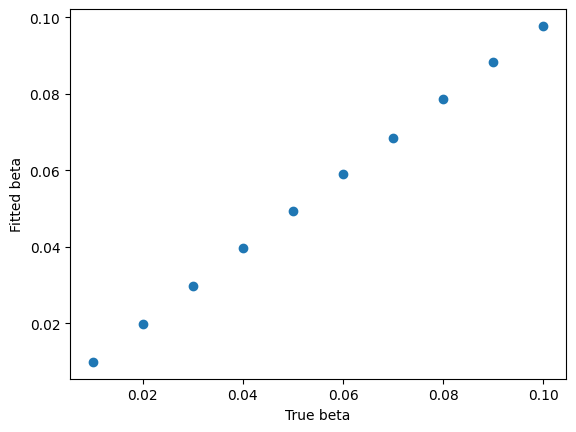

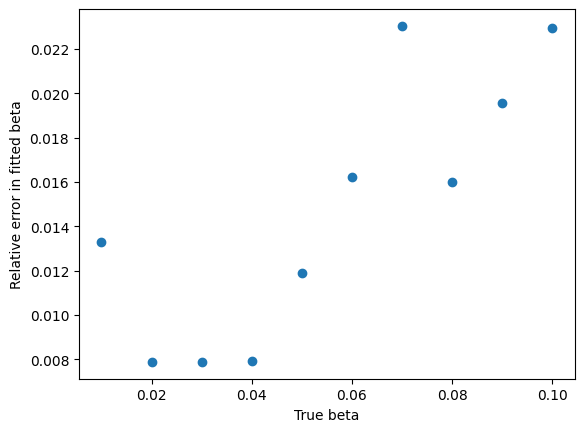

In [70]:
nticks = 730
t = np.arange(730)
pop = 1e5

seeds = [i for i in range(10)]
betas = [0.01 * i for i in range(1, 11)]
output = pd.DataFrame(columns=["seed", "beta", "cases", "fitted_beta", "fitted_size", "fitted_t0"])
scenario = pd.DataFrame(data=[["homenode", pop, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
for seed, beta in zip(seeds, betas):
    parameters = PropertySet({"seed": seed, "nticks": nticks, "verbose": True, "beta": beta})
    model = Model(scenario, parameters)
    model.components = [
        Susceptibility,
        Transmission,
    ]
    seed_infections_randomly_SI(model, ninfections=1)
    model.run()
    cases = [model.patches.cases[i][0] for i in range(nticks)]
    popt, pcov = curve_fit(SI_logistic, t, cases, p0=[0.05, 1.1e5, 1])

    output = pd.concat(
        [
            output,
            pd.DataFrame.from_dict(
                {
                    "seed": seed,
                    "beta": beta,
                    "cases": [np.array(cases)],
                    "fitted_beta": popt[0],
                    "fitted_size": popt[1],
                    "fitted_t0": popt[2],
                }
            ),
        ],
        ignore_index=True,
    )


plt.plot(output["beta"], output["fitted_beta"], "o")
plt.xlabel("True beta")
plt.ylabel("Fitted beta")
plt.figure()
plt.plot(output["beta"], (output["beta"] - output["fitted_beta"])/output['beta'], "o")
plt.xlabel("True beta")
plt.ylabel("Relative error in fitted beta")

In [71]:
output

,seed,beta,cases,fitted_beta,fitted_size,fitted_t0
0,0,0.01,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.009867,4.248758e+11,-29.361584
1,1,0.02,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.019842,1.001804e+05,37.353946
2,2,0.03,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.029763,1.000520e+05,72.752446
3,3,0.04,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.039684,1.000024e+05,35.313544
4,4,0.05,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.049405,1.000016e+05,47.800174
5,5,0.06,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.059027,1.000088e+05,10.746848
6,6,0.07,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, ...",0.068387,1.000112e+05,-1.713453
7,7,0.08,"[1, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, ...",0.078720,1.000047e+05,-8.607161
8,8,0.09,"[1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, ...",0.088240,1.000081e+05,3.627601
9,9,0.10,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.097706,1.000069e+05,14.326848


In [24]:
output

In [25]:
pd.DataFrame.from_dict({"a": 1, "b": 2, "c": [np.array([1, 2, 3])]})

,a,b,c
0,1,2,"[1, 2, 3]"
